<a href="https://colab.research.google.com/github/TheAmirHK/SaarstahlAM_demo/blob/main/SaarAM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

start_time = time.time()

In [104]:
customer_demands = [
    {"Type": "TGV","Delay": 2*7, "Quantity": 120, "Length": 108000, "Priority":5},
    {"Type": "TGV station","Delay": 2*7, "Quantity": 50, "Length": 56000, "Priority": 4},
    {"Type": "OUI","Delay": 4*7, "Quantity": 70, "Length": 32000, "Priority": 3},
    {"Type": "TER","Delay": 4*7, "Quantity": 150, "Length": 18000, "Priority": 2},
    {"Type": "DB","Delay": 3*7, "Quantity": 10, "Length": 18000, "Priority": 2},
    {"Type": "CFF","Delay": 3*7, "Quantity": 100, "Length": 10000, "Priority": 1}
    ]

In [105]:
def generate_patterns(customer_demands, defect_vector):
    rail_length = len(defect_vector)
    lengths = sorted(list(set([c["Length"] for c in customer_demands])))
    length_to_type = {c["Length"]: c["Type"] for c in customer_demands}
    type_to_priority = {c["Type"]: c["Priority"] for c in customer_demands}
    max_pieces = [int((rail_length) // l) for l in lengths]

    feasible_patterns = []

    for pattern in product(*(range(m + 1) for m in max_pieces)):
        total_length = sum(pattern[i] * lengths[i] for i in range(len(pattern)))
        if total_length <= rail_length and sum(pattern) > 0 and (rail_length - total_length) / rail_length <= 0.5 :

            items = []
            total_priority = 0
            for i, count in enumerate(pattern):
                if count > 0:
                    rail_type = length_to_type[lengths[i]]
                    items.extend([{"Type": rail_type, "Length": lengths[i]}] * count)
                    total_priority +=  type_to_priority[rail_type]* count  # cummulative priority for the cutting-pattern

            start_pos = 0
            feasible_patterns.append({
                "items": items,
                "start": start_pos ,
                "end": (start_pos + int(total_length)),
                "waste": rail_length - total_length,
                "pattern": pattern,
                "priority": total_priority,
                "total_length": total_length
            })

    return feasible_patterns

In [106]:
def print_info(patterns, max_print=2, more=True):
    print(f"Total feasible patternss generated: {len(patterns)}")
    for i, combination in enumerate(patterns[:max_print], 1):
        total_waste = combination['waste']
        total_priority = combination['priority']
        print(f"Pattern {i}: Total Waste = {total_waste:.2f} (meters) and Priority = {total_priority} ")
        if more:
          for pattern in combination[:-1]:
              print(f"  Position: {pattern['start']} to {pattern['end']}")
              print(f"  Waste: {pattern['waste']}")
              print("  Pieces:")
              for item in pattern['items']:
                  print(f"    - {item['Type']} (Length: {item['Length']})")
              print(f"  Pattern tuple: {pattern['pattern']}")
              print(f"  Priority: {pattern['priority']}")
              print(f"  Total length: {pattern['total_length']}")

In [107]:
def plot_patterns(defect_vector, patterns, max_plot=10):

    plt.figure(figsize=(18, 8))

    rail_length = len(defect_vector)

    defect_indices = np.where(defect_vector == 1)[0]
    defect_positions = defect_indices

    plt.barh(0, rail_length, left=0, height=0.5, color='lightgray', edgecolor='black')
    plt.text(rail_length / 2, 0, "Rail", va='center', ha='center')

    for pos in defect_positions:
        plt.barh(0, 1 , left=pos, height=0.5, color='red', alpha=0.7)

    for i, pattern in enumerate(patterns[:max_plot]):
        y_pos = -(i + 1) * 0.5
        color = plt.cm.tab20(i % 20)
        current_pos = pattern['start']
        for item in pattern['items']:
            plt.barh(y_pos + 0.05, item['Length'],
                    left=current_pos, height=0.3,
                    color=color, alpha=0.9, edgecolor='black')
            plt.text(current_pos + item['Length'] / 2, y_pos + 0.05,
                    f"{item['Type']} : {item['Length']}m",
                    va='center', ha='center', fontsize=8)
            current_pos += item['Length']

    plt.xlabel('Position on rail (meters)')
    plt.yticks([])
    plt.title(f'Feasible Cutting Patterns (Showing {min(max_plot, len(patterns))} of {len(patterns)})')
    plt.xlim(0, rail_length)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [108]:
def get_pareto_front(combinations):
    pareto_front = []
    for i, combo in enumerate(combinations):
        is_dominated = False
        for j, other_combo in enumerate(combinations):
            if i != j:
                if (other_combo['waste'] <= combo['waste'] and
                        other_combo['priority'] >= combo['priority'] and
                        (other_combo['waste'] < combo['waste'] or
                         other_combo['priority'] > combo['priority'])):
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_front.append(combo)
    return pareto_front

In [109]:
def plot_pareto_front(combinations):
    waste_values = [combo['waste'] for combo in combinations]
    priority_values = [combo['priority'] for combo in combinations]

    plt.figure(figsize=(10, 6))
    plt.scatter(waste_values, priority_values, marker='o', label='Pareto Optimal Solutions', color='red', s=100)

    plt.xlabel("Total Waste (meters)")
    plt.ylabel("Total Priority")
    plt.title("Pareto Front")
    plt.grid(True)
    plt.legend()
    plt.show()

In [110]:
rail_length = [0]*115000
patterns = generate_patterns(customer_demands, rail_length)
sorted_list = sorted(patterns, key=lambda x: x['waste'], reverse=False )

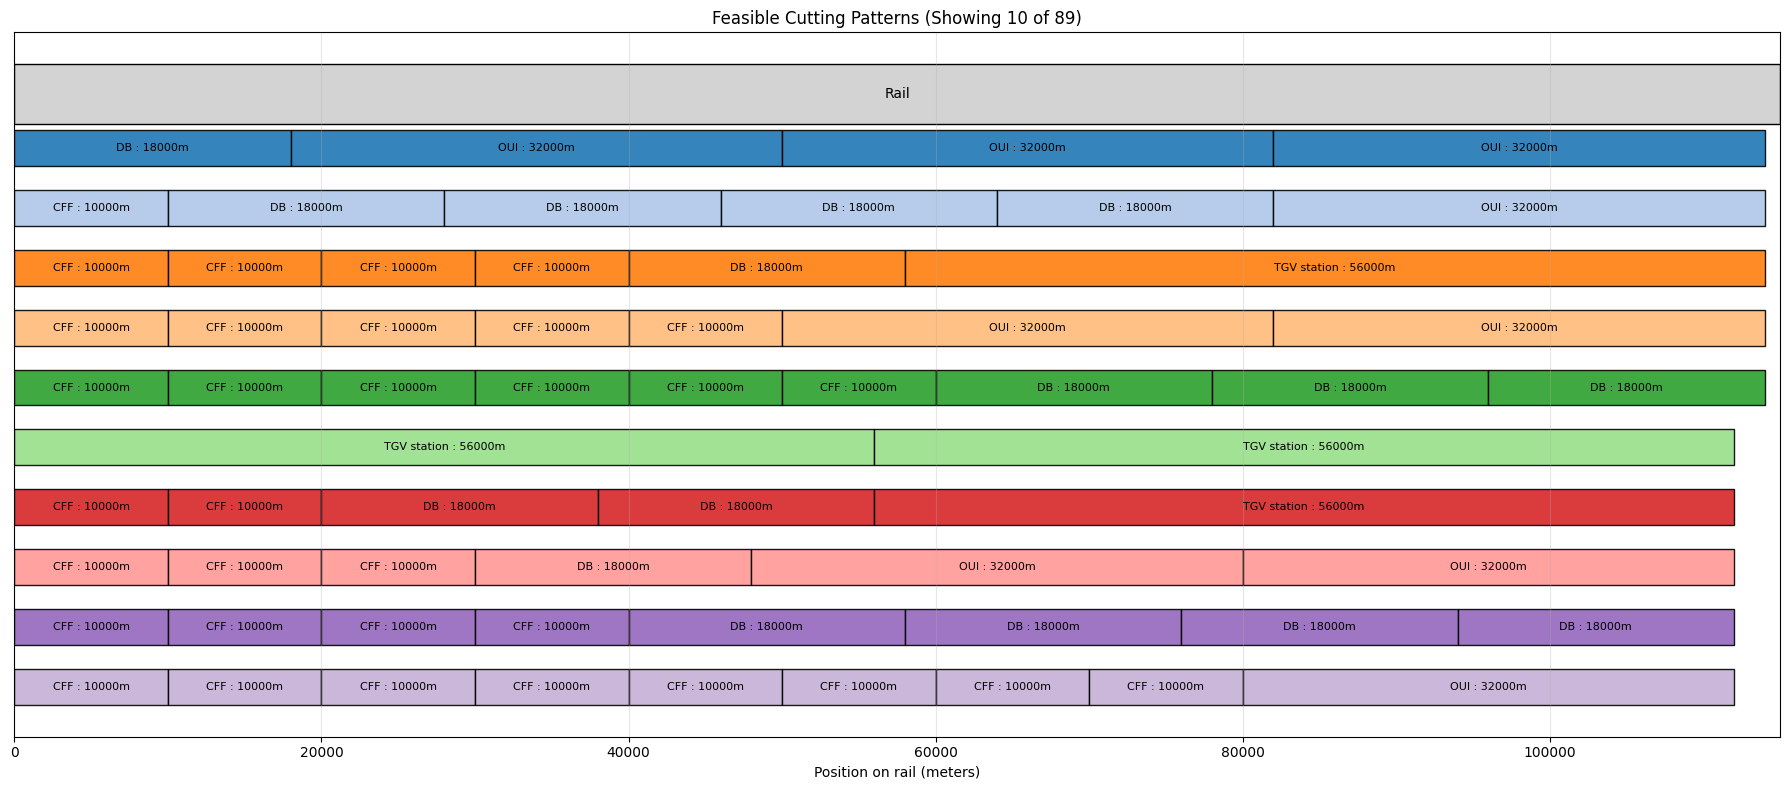

In [111]:
plot_patterns(rail_length, sorted_list)

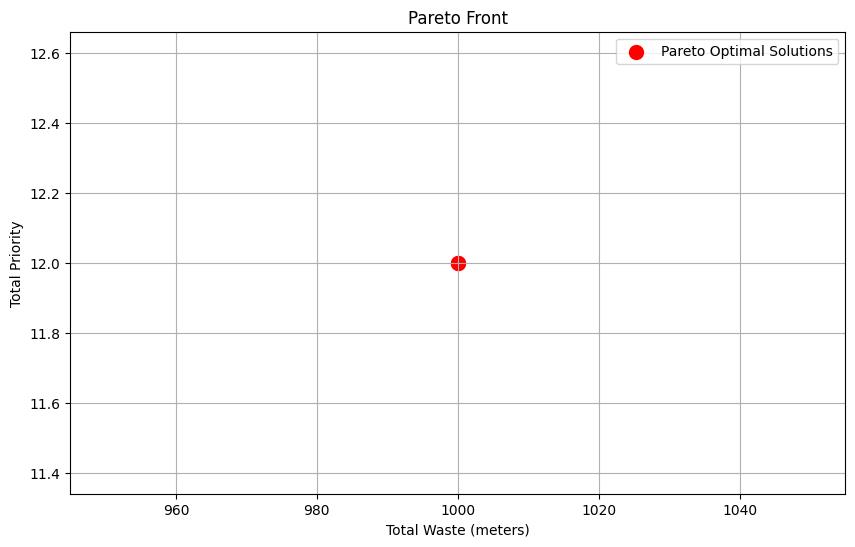

In [112]:
pareto_optimal_combinations = get_pareto_front(patterns)
plot_pareto_front(pareto_optimal_combinations)

In [113]:
print_info(pareto_optimal_combinations, max_print=3, more=False)

Total feasible patternss generated: 2
Pattern 1: Total Waste = 1000.00 (meters) and Priority = 12 
Pattern 2: Total Waste = 1000.00 (meters) and Priority = 12 


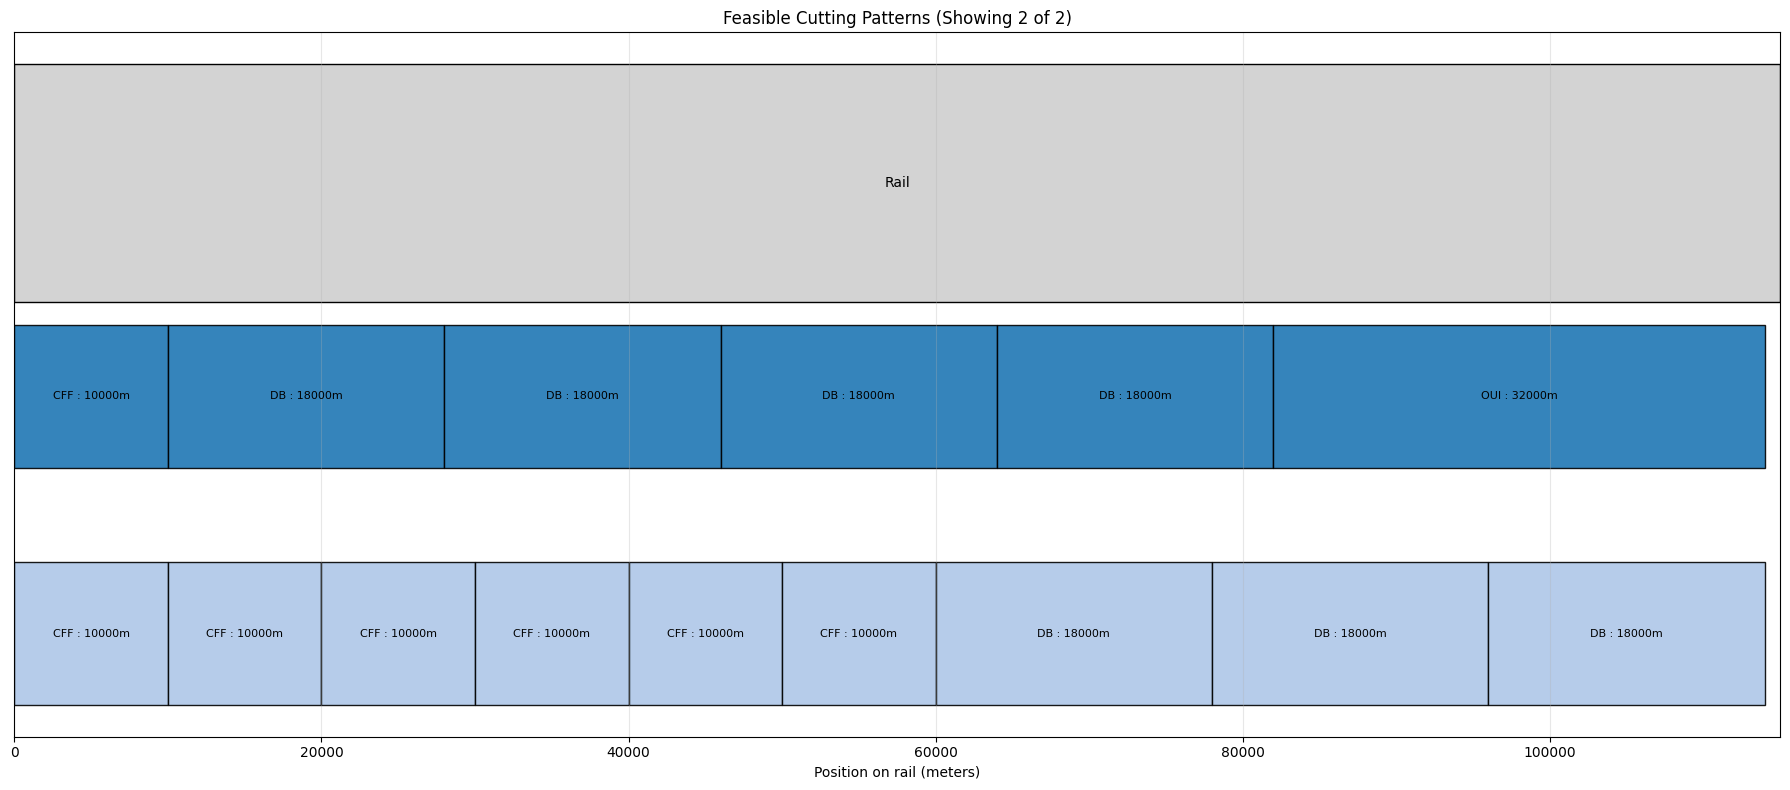

In [114]:
plot_patterns(rail_length, pareto_optimal_combinations)